In [1]:
import matplotlib.pyplot as plt
from google.colab import drive
import glob
import matplotlib.image as mpimg
import string 
import torch.nn as nn 
import numpy as np
import torch
drive.mount('/content/gdrive')
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from torch.nn.utils.rnn import pad_sequence

Mounted at /content/gdrive


### Download and unzip data:

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"banafshehk","key":"946ffc3d6cf20a7c88dfd95ddd626e76"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 

kaggle.json


In [ ]:
 ! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-15 08:36:45           5384  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2975  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            351  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1801  
imsparsh/musicnet-dataset                                   MusicNet Dataset

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.03G/1.04G [00:11<00:00, 133MB/s]
100% 1.04G/1.04G [00:11<00:00, 99.0MB/s]


In [ ]:
!unzip -q /content/flickr8k.zip -d /content/gdrive/My\ Drive/dataset
print("Done")

Done


### Read and pre process data:

In [2]:
class Data:
    def __init__(self, file_name):
        self.disc = []
        self.imgs = {}
        self.vocabtoindex  = {"<SOS>":0,"<padd>":1,"<EOS>":2, "<UNK>":3}
        self.vocabcount  = {}
        self.indextovocab  = {0:"<SOS>",1:"<padd>",2:"<EOS>", 3: "<UNK>"}
        #it = 0
        with open(file_name + "captions.txt") as file_in:
            Dict = {}
            for line in file_in:
                #it = it+1
                #if it > 1000:
                #    break
                img, disc = line.split(",")[0], ''.join(line.split(",")[1:])
                disc = self.discription_cleaning(disc)
                if img in Dict:
                    Dict[img].append(disc)
                    self.imgs[img] = mpimg.imread(file_name+"Images/"+img)
                else:
                    Dict[img] = [disc]
        del Dict['image']
        for img in [*Dict]:
            Dict[img] = self.tokenizer(Dict[img])
        self.cap_test = {}
        self.cap_train = {}
        self.cap_valid = {}
        
        keys = list(Dict.keys())
        test = np.random.choice(len(keys),int(len(keys)/10))
        test, valid = test[0:int(len(test)/2)],test[int(len(test)/2):]
        for k in test:
            self.cap_test[keys[k]] = Dict[keys[k]]
        for k in valid:
            self.cap_valid[keys[k]] = Dict[keys[k]]
        for k in range(len(keys)):
            if k in test or k in valid:
                continue
            self.cap_train[keys[k]] = Dict[keys[k]]
        #print(Dict)
 
    def discription_cleaning(self,disc):
        '''remove punctioation, convert to lower case and tokenize return index of tokens'''
        disc = disc.translate(str.maketrans('', '', string.punctuation))
        disc = disc.lower().replace(" \n","").replace("\n","").replace("  "," ")
        token = ("<SOS> "+disc+" <EOS>").split(" ")
        for t in token:
            if t not in self.vocabtoindex:
                if t in self.vocabcount:
                    if self.vocabcount[t] > 3:
                        self.vocabtoindex[t] = len(self.vocabtoindex)
                        self.indextovocab[len(self.indextovocab)] = t
                    else:
                        self.vocabcount[t] = self.vocabcount[t] + 1
                else:
                    self.vocabcount[t] = 1
        return token
    def tokenizer(self, disc):
        #print(disc)
        token = []
        for s in disc:
            temp = []
            for d in s:
                if d not in self.vocabtoindex:
                    temp.append(3)#"<UNK>"
                else:
                    temp.append(self.vocabtoindex[d])
            token.append(temp)
        #print(token)
        return token
 
    def get_padd(self,length, d):
        '''add padding so that len(d) == length'''
        for i in range(length-len(d)):
            d[-1] = self.vocabtoindex["<padd>"]
            d.append(self.vocabtoindex["<EOS>"])
            #d.append(self.vocabtoindex["<padd>"])
        return np.array(d)
        #return torch.from_numpy(np.array(disc_batch))

In [3]:
data = Data("/content/gdrive/My Drive/dataset/")

In [ ]:
RGB_mean = np.mean([[np.sum(data.imgs[img][:,:,0])/(data.imgs[img].shape[0]*data.imgs[img].shape[1]),np.sum(data.imgs[img][:,:,1])/(data.imgs[img].shape[0]*data.imgs[img].shape[1]),np.sum(data.imgs[img][:,:,2])/(data.imgs[img].shape[0]*data.imgs[img].shape[1])] for img in [*data.imgs]],axis = 0)
print(RGB_mean)
RGB_std = np.std([[np.sum(data.imgs[img][:,:,0])/(data.imgs[img].shape[0]*data.imgs[img].shape[1]),np.sum(data.imgs[img][:,:,1])/(data.imgs[img].shape[0]*data.imgs[img].shape[1]),np.sum(data.imgs[img][:,:,2])/(data.imgs[img].shape[0]*data.imgs[img].shape[1])] for img in [*data.imgs]],axis = 0,ddof=1)
print(RGB_std)

[116.79727365 113.75486353 102.99875463]
[32.20158116 32.63587203 37.54384899]


### Training:

In [4]:
def creat_minibatch(dictionary,batch_size=20):
    keys = [*dictionary]
    merged = []
    for k in keys:
        merged.append([k,0])
        merged.append([k,1])
        merged.append([k,2])
        merged.append([k,3])
        merged.append([k,4])
    np.random.shuffle(merged)
    batch = []
    i = 0
    while i < len(merged):
        x = merged[i:i+batch_size]
        batch.append(x)
        i = i + batch_size
    return batch

In [5]:
class Network(nn.Module):
    def __init__(self,input,hidden,vocab_size,layers):
        super(Network,self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features,input)
        self.embed = nn.Embedding(vocab_size, input, padding_idx= 3)
        self.lstm = nn.LSTM(input,hidden,layers, batch_first=True)
        self.linear = nn.Linear(hidden,vocab_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, input, disc):
        input = self.resnet18(input)
        embeded = self.embed(disc)
        x = torch.cat((input.unsqueeze(1),embeded),dim=1) 
        lstm,_ = self.lstm(x)
        return self.linear(lstm)

    def captioning(self, input, max_length, data):
        caption_prediction = []

        input_data = self.resnet18(input).unsqueeze(0)
        states = None

        for _ in range(max_length):
            hiddens, states = self.lstm(input_data, states)
            output = self.linear(hiddens.squeeze(0))
            predicted_index = output.argmax(1)
            input_data = self.embed(predicted_index).unsqueeze(0)
            caption_prediction.append(predicted_index.item())

            if data.indextovocab[predicted_index.item()] == "<EOS>":
                break

        return [data.indextovocab[cp] for cp in caption_prediction]
    

#### Freezing RN1

In [ ]:
! rm /content/gdrive/MyDrive/v1logg.txt
! printf '' > /content/gdrive/MyDrive/v1logg.txt

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
net = Network(300,256,len(data.indextovocab),2)
if False:
    net.load_state_dict(torch.load('/content/gdrive/MyDrive/netnoRNtraining_v1'))
    net.eval()
net.cuda()
 
 
for name, param in net.resnet18.named_parameters():
    if "fc.weight" in name or "fc.bias" in name :
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer =  optim.Adam(net.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss(ignore_index=data.vocabtoindex["<padd>"])
trainlosslog = []
validlosslog = []
for i in range(30):
    batchkeys = creat_minibatch(data.cap_train,200)
    losslog = []
    for batchkey in batchkeys:
        length = np.max([len(data.cap_train[key[0]][key[1]]) for key in batchkey])
        imgs = []
        captions = []
        for key in batchkey:
            img = transform(Image.fromarray(np.uint8(data.imgs[key[0]])).convert('RGB'))
            caption = torch.Tensor(data.cap_train[key[0]][key[1]]).to(torch.int64)
            #caption = data.get_padd(length, data.cap_train[key[0]][key[1]])
            imgs.append(img.cpu().detach().numpy())
            captions.append(caption)
        optimizer.zero_grad()
        pad = pad_sequence(captions, padding_value = data.vocabtoindex["<padd>"], batch_first=True)
        output = net(torch.Tensor(imgs).cuda(),pad[:,:-1].cuda())
        output = loss(output.reshape(-1, output.shape[2]).cuda(), pad.view(-1).cuda())
        losslog.append(output.cpu().detach().numpy())
        optimizer.zero_grad()
        output.backward()
        optimizer.step()  
    trainlosslog.append(np.mean(losslog))
    length = np.max([[len(caption) for caption in data.cap_valid[key]] for key in [*data.cap_valid]])
    imgs = []
    captions = []
    for key in [*data.cap_valid]:
        img = transform(Image.fromarray(np.uint8(data.imgs[key])).convert('RGB'))
        for caption in data.cap_valid[key]:
            caption = torch.Tensor(caption).to(torch.int64)
            imgs.append(img.cpu().detach().numpy())
            captions.append(caption)
    pad = pad_sequence(captions, padding_value = data.vocabtoindex["<padd>"], batch_first=True)
    output = net(torch.Tensor(imgs).cuda(),pad[:,:-1].cuda())
    output = loss(output.reshape(-1, output.shape[2]).cuda(), pad.view(-1).cuda())
    with open("/content/gdrive/MyDrive/v1logg.txt", "a") as myfile:
        myfile.write(str(trainlosslog[-1]))
    print(trainlosslog)
    validlosslog.append(output.item())
    print(validlosslog)
    torch.save(net.state_dict(), '/content/gdrive/MyDrive/netnoRNtraining_v1')

[4.650398]
[4.0175700187683105]
[4.650398, 3.7089443]
[4.0175700187683105, 3.506401538848877]
[4.650398, 3.7089443, 3.3607543]
[4.0175700187683105, 3.506401538848877, 3.282923460006714]
[4.650398, 3.7089443, 3.3607543, 3.169782]
[4.0175700187683105, 3.506401538848877, 3.282923460006714, 3.154189348220825]
[4.650398, 3.7089443, 3.3607543, 3.169782, 3.0312393]
[4.0175700187683105, 3.506401538848877, 3.282923460006714, 3.154189348220825, 3.0473952293395996]
[4.650398, 3.7089443, 3.3607543, 3.169782, 3.0312393, 2.909986]
[4.0175700187683105, 3.506401538848877, 3.282923460006714, 3.154189348220825, 3.0473952293395996, 2.9535036087036133]
[4.650398, 3.7089443, 3.3607543, 3.169782, 3.0312393, 2.909986, 2.816442]
[4.0175700187683105, 3.506401538848877, 3.282923460006714, 3.154189348220825, 3.0473952293395996, 2.9535036087036133, 2.9023613929748535]
[4.650398, 3.7089443, 3.3607543, 3.169782, 3.0312393, 2.909986, 2.816442, 2.726364]
[4.0175700187683105, 3.506401538848877, 3.282923460006714, 3.15

KeyboardInterrupt: ignored

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
net = Network(300,256,len(data.indextovocab),2)
if True:
    net.load_state_dict(torch.load('/content/gdrive/MyDrive/netnoRNtraining_v1'))
    #net.eval()
net.cuda()
 
 
for name, param in net.resnet18.named_parameters():
    if "fc.weight" in name or "fc.bias" in name :
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer =  optim.Adam(net.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss(ignore_index=data.vocabtoindex["<padd>"])
trainlosslog = []
validlosslog = []
for i in range(10):
    batchkeys = creat_minibatch(data.cap_train,200)
    losslog = []
    for batchkey in batchkeys:
        length = np.max([len(data.cap_train[key[0]][key[1]]) for key in batchkey])
        imgs = []
        captions = []
        for key in batchkey:
            img = transform(Image.fromarray(np.uint8(data.imgs[key[0]])).convert('RGB'))
            caption = torch.Tensor(data.cap_train[key[0]][key[1]]).to(torch.int64)
            #caption = data.get_padd(length, data.cap_train[key[0]][key[1]])
            imgs.append(img.cpu().detach().numpy())
            captions.append(caption)
        optimizer.zero_grad()
        pad = pad_sequence(captions, padding_value = data.vocabtoindex["<padd>"], batch_first=True)
        output = net(torch.Tensor(imgs).cuda(),pad[:,:-1].cuda())
        output = loss(output.reshape(-1, output.shape[2]).cuda(), pad.view(-1).cuda())
        losslog.append(output.cpu().detach().numpy())
        optimizer.zero_grad()
        output.backward()
        optimizer.step()  
    trainlosslog.append(np.mean(losslog))
    length = np.max([[len(caption) for caption in data.cap_valid[key]] for key in [*data.cap_valid]])
    imgs = []
    captions = []
    for key in [*data.cap_valid]:
        img = transform(Image.fromarray(np.uint8(data.imgs[key])).convert('RGB'))
        for caption in data.cap_valid[key]:
            caption = torch.Tensor(caption).to(torch.int64)
            imgs.append(img.cpu().detach().numpy())
            captions.append(caption)
    pad = pad_sequence(captions, padding_value = data.vocabtoindex["<padd>"], batch_first=True)
    output = net(torch.Tensor(imgs).cuda(),pad[:,:-1].cuda())
    output = loss(output.reshape(-1, output.shape[2]).cuda(), pad.view(-1).cuda())
    with open("/content/gdrive/MyDrive/v1logg.txt", "a") as myfile:
        myfile.write(str(trainlosslog[-1]))
    print(trainlosslog)
    validlosslog.append(output.item())
    print(validlosslog)
    torch.save(net.state_dict(), '/content/gdrive/MyDrive/netnoRNtraining_v1_1')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



[2.5463922]
[2.548149347305298]
[2.5463922, 2.4657352]
[2.548149347305298, 2.5389175415039062]
[2.5463922, 2.4657352, 2.4029257]
[2.548149347305298, 2.5389175415039062, 2.5405611991882324]
[2.5463922, 2.4657352, 2.4029257, 2.3438005]
[2.548149347305298, 2.5389175415039062, 2.5405611991882324, 2.5400636196136475]
[2.5463922, 2.4657352, 2.4029257, 2.3438005, 2.2884507]
[2.548149347305298, 2.5389175415039062, 2.5405611991882324, 2.5400636196136475, 2.5404880046844482]


KeyboardInterrupt: ignored

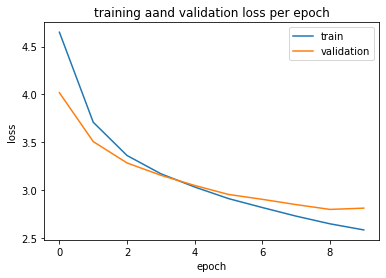

In [ ]:
plt.plot(trainlosslog,label="train")
plt.plot(validlosslog,label="validation")
plt.legend()
plt.title("training aand validation loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
net = Network(300,256,len(data.indextovocab),2)
if True:
    net.load_state_dict(torch.load('/content/gdrive/MyDrive/netnoRNtraining_v1'))
    net.eval()
net.cuda()

Network(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

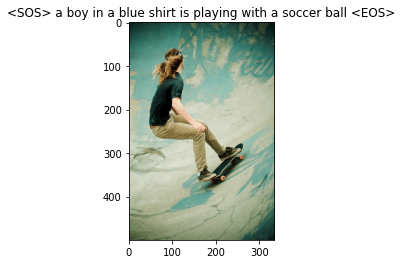

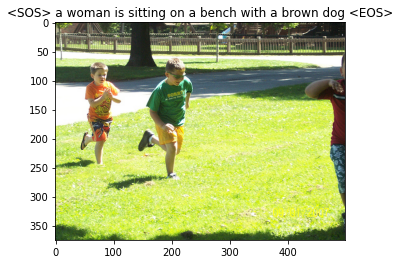

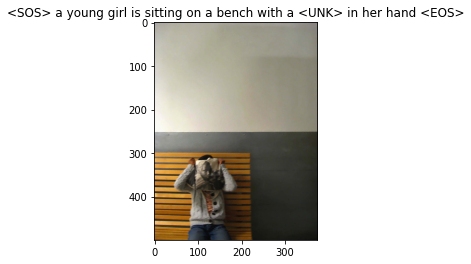

In [ ]:
test = np.random.choice([*data.cap_test],3)
for k in test:
    img = transform(Image.fromarray(np.uint8(data.imgs[k])).convert('RGB'))
    #for caption in data.cap_test[k]:
    #    caption = data.get_padd(20, caption)
    #    print(caption)
    caption = " ".join(net.captioning(torch.Tensor(img).unsqueeze(0).cuda(), 30, data))
    imgplot = plt.imshow(data.imgs[k])
    plt.title(caption)
    plt.show()

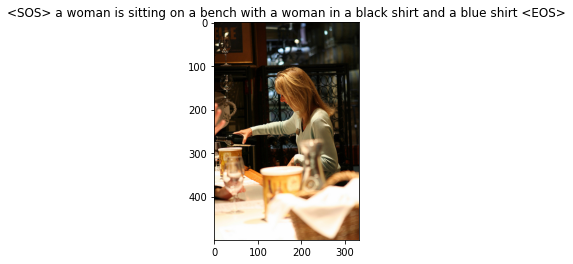

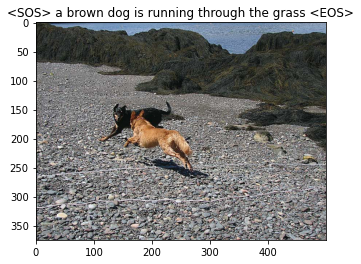

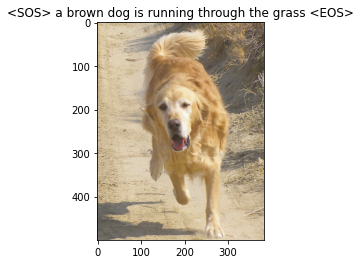

In [ ]:
test = np.random.choice([*data.cap_test],3)
for k in test:
    img = transform(Image.fromarray(np.uint8(data.imgs[k])).convert('RGB'))
    #for caption in data.cap_test[k]:
    #    caption = data.get_padd(20, caption)
    #    print(caption)
    caption = " ".join(net.captioning(torch.Tensor(img).unsqueeze(0).cuda(), 30, data))
    imgplot = plt.imshow(data.imgs[k])
    plt.title(caption)
    plt.show()

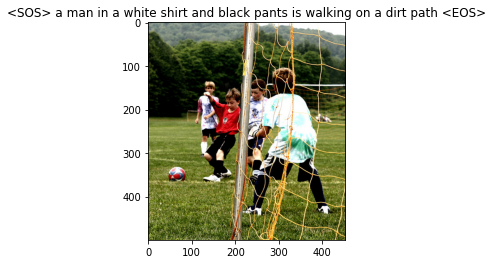

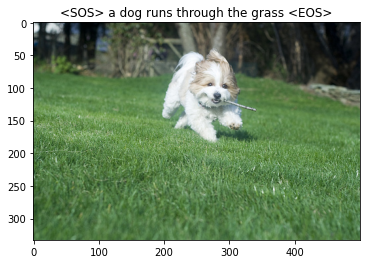

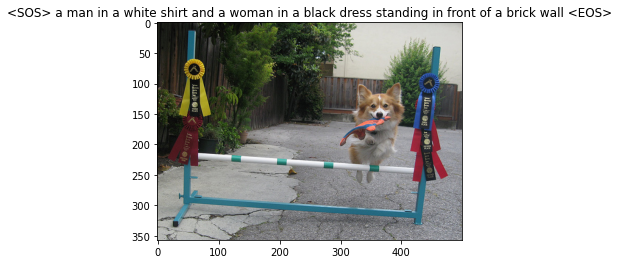

In [ ]:
test = np.random.choice([*data.cap_test],3)
for k in test:
    img = transform(Image.fromarray(np.uint8(data.imgs[k])).convert('RGB'))
    #for caption in data.cap_test[k]:
    #    caption = data.get_padd(20, caption)
    #    print(caption)
    caption = " ".join(net.captioning(torch.Tensor(img).unsqueeze(0).cuda(), 30, data))
    imgplot = plt.imshow(data.imgs[k])
    plt.title(caption)
    plt.show()

#### taining RN18

In [ ]:
! rm /content/gdrive/MyDrive/v2logg.txt
! printf '' > /content/gdrive/MyDrive/v2logg.txt

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
net = Network(300,256,len(data.indextovocab),2)
if False:
    net.load_state_dict(torch.load('/content/gdrive/MyDrive/netwithRNtraining_v8'))
    net.eval()
net.cuda()
 
 

optimizer =  optim.Adam(net.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss(ignore_index=data.vocabtoindex["<padd>"])
trainlosslog = []
validlosslog = []
for i in range(10):
    batchkeys = creat_minibatch(data.cap_train,200)
    losslog = []
    for batchkey in batchkeys:
        length = np.max([len(data.cap_train[key[0]][key[1]]) for key in batchkey])
        imgs = []
        captions = []
        for key in batchkey:
            img = transform(Image.fromarray(np.uint8(data.imgs[key[0]])).convert('RGB'))
            caption = torch.Tensor(data.cap_train[key[0]][key[1]]).to(torch.int64)
            #caption = data.get_padd(length, data.cap_train[key[0]][key[1]])
            imgs.append(img.cpu().detach().numpy())
            captions.append(caption)
        optimizer.zero_grad()
        pad = pad_sequence(captions, padding_value = data.vocabtoindex["<padd>"], batch_first=True)
        output = net(torch.Tensor(imgs).cuda(),pad[:,:-1].cuda())
        output = loss(output.reshape(-1, output.shape[2]).cuda(), pad.view(-1).cuda())
        losslog.append(output.cpu().detach().numpy())
        optimizer.zero_grad()
        output.backward()
        optimizer.step()  
    trainlosslog.append(np.mean(losslog))
    batchkeys = creat_minibatch(data.cap_train,200)
    temp = []
    for batchkey in batchkeys:
        length = np.max([len(data.cap_train[key[0]][key[1]]) for key in batchkey])
        imgs = []
        captions = []
        for key in batchkey:
            img = transform(Image.fromarray(np.uint8(data.imgs[key[0]])).convert('RGB'))
            caption = torch.Tensor(data.cap_train[key[0]][key[1]]).to(torch.int64)
            #caption = data.get_padd(length, data.cap_train[key[0]][key[1]])
            imgs.append(img.cpu().detach().numpy())
            captions.append(caption)
        pad = pad_sequence(captions, padding_value = data.vocabtoindex["<padd>"], batch_first=True)
        output = net(torch.Tensor(imgs).cuda(),pad[:,:-1].cuda())
        output = loss(output.reshape(-1, output.shape[2]).cuda(), pad.view(-1).cuda())
        temp.append(output.item())
    with open("/content/gdrive/MyDrive/v2logg.txt", "a") as myfile:
        myfile.write(str(trainlosslog[-1]))
    print(trainlosslog)
    validlosslog.append(np.mean(temp))
    print(validlosslog)
    torch.save(net.state_dict(), '/content/gdrive/MyDrive/netwithRNtraining_v8')

[4.5762463]
[3.8913089529327722]
[4.5762463, 3.6250772]
[3.8913089529327722, 3.4015049221722977]
[4.5762463, 3.6250772, 3.2900984]
[3.8913089529327722, 3.4015049221722977, 3.1630817638791124]
[4.5762463, 3.6250772, 3.2900984, 3.10422]
[3.8913089529327722, 3.4015049221722977, 3.1630817638791124, 3.0055206936338674]
[4.5762463, 3.6250772, 3.2900984, 3.10422, 2.9776604]
[3.8913089529327722, 3.4015049221722977, 3.1630817638791124, 3.0055206936338674, 2.8985107787277387]
[4.5762463, 3.6250772, 3.2900984, 3.10422, 2.9776604, 2.8767397]
[3.8913089529327722, 3.4015049221722977, 3.1630817638791124, 3.0055206936338674, 2.8985107787277387, 2.8030328154563904]
[4.5762463, 3.6250772, 3.2900984, 3.10422, 2.9776604, 2.8767397, 2.793659]
[3.8913089529327722, 3.4015049221722977, 3.1630817638791124, 3.0055206936338674, 2.8985107787277387, 2.8030328154563904, 2.7323934474717015]
[4.5762463, 3.6250772, 3.2900984, 3.10422, 2.9776604, 2.8767397, 2.793659, 2.7238145]
[3.8913089529327722, 3.4015049221722977, 

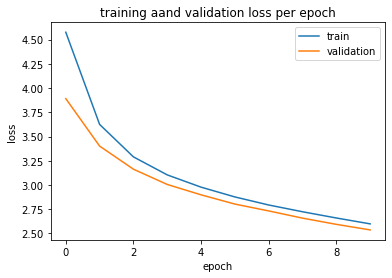

In [7]:
plt.plot(trainlosslog,label="train")
plt.plot(validlosslog,label="validation")
plt.legend()
plt.title("training aand validation loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

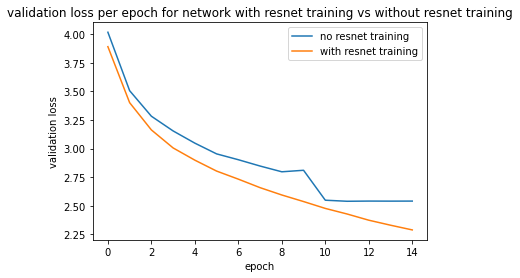

In [18]:
plt.plot(v1,label="no resnet training")
plt.plot(v2,label="with resnet training")
plt.legend()
plt.title("validation loss per epoch for network with resnet training vs without resnet training")
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.show()

In [ ]:
for i in range(5):
    batchkeys = creat_minibatch(data.cap_train,200)
    losslog = []
    for batchkey in batchkeys:
        length = np.max([len(data.cap_train[key[0]][key[1]]) for key in batchkey])
        imgs = []
        captions = []
        for key in batchkey:
            img = transform(Image.fromarray(np.uint8(data.imgs[key[0]])).convert('RGB'))
            caption = torch.Tensor(data.cap_train[key[0]][key[1]]).to(torch.int64)
            #caption = data.get_padd(length, data.cap_train[key[0]][key[1]])
            imgs.append(img.cpu().detach().numpy())
            captions.append(caption)
        optimizer.zero_grad()
        pad = pad_sequence(captions, padding_value = data.vocabtoindex["<padd>"], batch_first=True)
        output = net(torch.Tensor(imgs).cuda(),pad[:,:-1].cuda())
        output = loss(output.reshape(-1, output.shape[2]).cuda(), pad.view(-1).cuda())
        losslog.append(output.cpu().detach().numpy())
        optimizer.zero_grad()
        output.backward()
        optimizer.step()  
    trainlosslog.append(np.mean(losslog))
    batchkeys = creat_minibatch(data.cap_train,500)
    temp = []
    for batchkey in batchkeys:
        length = np.max([len(data.cap_train[key[0]][key[1]]) for key in batchkey])
        imgs = []
        captions = []
        for key in batchkey:
            img = transform(Image.fromarray(np.uint8(data.imgs[key[0]])).convert('RGB'))
            caption = torch.Tensor(data.cap_train[key[0]][key[1]]).to(torch.int64)
            #caption = data.get_padd(length, data.cap_train[key[0]][key[1]])
            imgs.append(img.cpu().detach().numpy())
            captions.append(caption)
        pad = pad_sequence(captions, padding_value = data.vocabtoindex["<padd>"], batch_first=True)
        output = net(torch.Tensor(imgs).cuda(),pad[:,:-1].cuda())
        output = loss(output.reshape(-1, output.shape[2]).cuda(), pad.view(-1).cuda())
        temp.append(output.item())
    with open("/content/gdrive/MyDrive/v2logg.txt", "a") as myfile:
        myfile.write(str(trainlosslog[-1]))
    print(trainlosslog)
    validlosslog.append(np.mean(temp))
    print(validlosslog)
    torch.save(net.state_dict(), '/content/gdrive/MyDrive/netwithRNtraining_v8_1')

[4.5762463, 3.6250772, 3.2900984, 3.10422, 2.9776604, 2.8767397, 2.793659, 2.7238145, 2.6594567, 2.598815, 2.5436616]
[3.8913089529327722, 3.4015049221722977, 3.1630817638791124, 3.0055206936338674, 2.8985107787277387, 2.8030328154563904, 2.7323934474717015, 2.658006867636805, 2.593847921361094, 2.536426930323891, 2.4763920758221603]
[4.5762463, 3.6250772, 3.2900984, 3.10422, 2.9776604, 2.8767397, 2.793659, 2.7238145, 2.6594567, 2.598815, 2.5436616, 2.4933312]
[3.8913089529327722, 3.4015049221722977, 3.1630817638791124, 3.0055206936338674, 2.8985107787277387, 2.8030328154563904, 2.7323934474717015, 2.658006867636805, 2.593847921361094, 2.536426930323891, 2.4763920758221603, 2.427674045433869]
[4.5762463, 3.6250772, 3.2900984, 3.10422, 2.9776604, 2.8767397, 2.793659, 2.7238145, 2.6594567, 2.598815, 2.5436616, 2.4933312, 2.4429133]
[3.8913089529327722, 3.4015049221722977, 3.1630817638791124, 3.0055206936338674, 2.8985107787277387, 2.8030328154563904, 2.7323934474717015, 2.658006867636805

read network with no resnet training to compare:

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
net1 = Network(300,256,len(data.indextovocab),2)
if True:
    net1.load_state_dict(torch.load('/content/gdrive/MyDrive/netnoRNtraining_v1'))
    net1.eval()
net1.cuda()

Network(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
net2 = Network(300,256,len(data.indextovocab),2)
if True:
    net2.load_state_dict(torch.load('/content/gdrive/MyDrive/netwithRNtraining_v8'))
    net2.eval()
net2.cuda()

Network(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

comparing results:

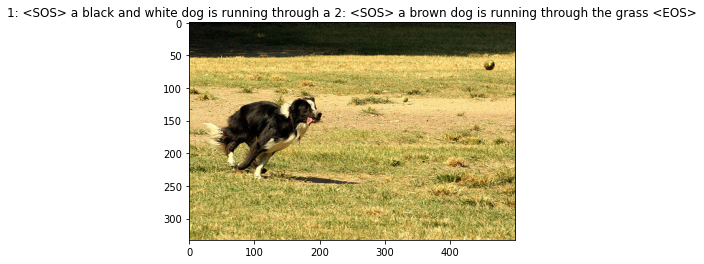

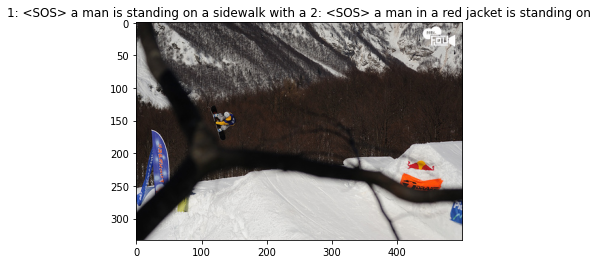

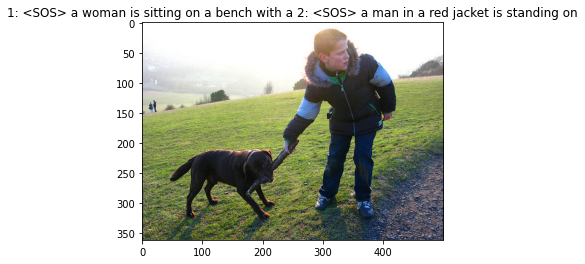

In [ ]:
test = np.random.choice([*data.cap_test],3)
for k in test:
    img = transform(Image.fromarray(np.uint8(data.imgs[k])).convert('RGB'))
    #for caption in data.cap_test[k]:
    #    caption = data.get_padd(20, caption)
    #    print(caption)
    caption1 = " ".join(net1.captioning(torch.Tensor(img).unsqueeze(0).cuda(), 10, data))
    caption2 = " ".join(net2.captioning(torch.Tensor(img).unsqueeze(0).cuda(), 10, data))
    imgplot = plt.imshow(data.imgs[k])
    plt.title("1: "+caption1+" 2: "+caption2)
    plt.show()

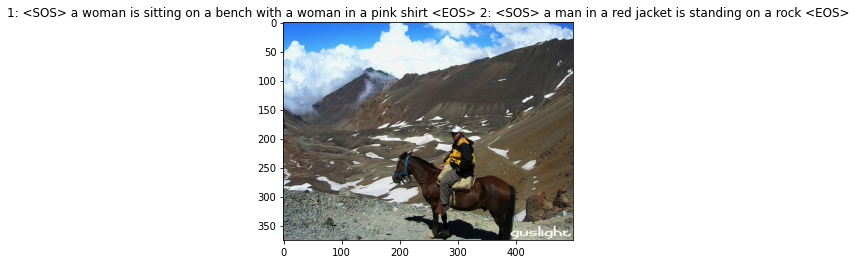

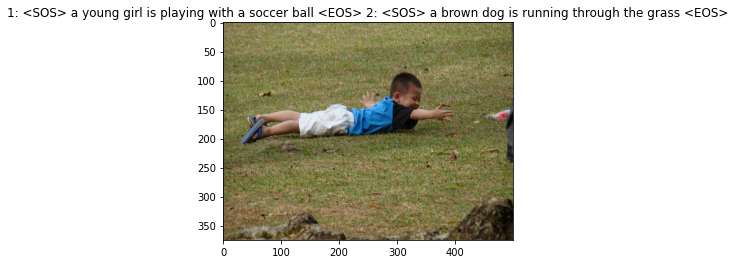

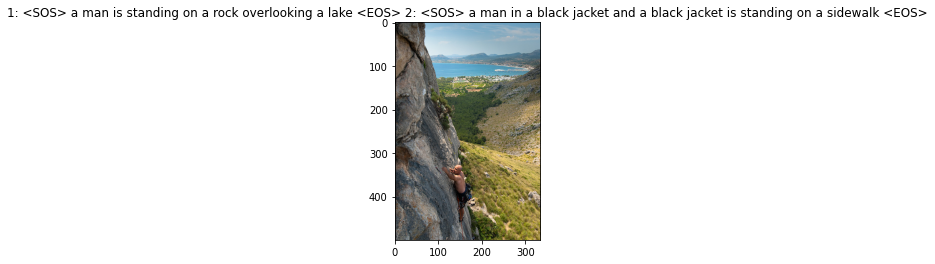

In [ ]:
test = np.random.choice([*data.cap_test],3)
for k in test:
    img = transform(Image.fromarray(np.uint8(data.imgs[k])).convert('RGB'))
    #for caption in data.cap_test[k]:
    #    caption = data.get_padd(20, caption)
    #    print(caption)
    caption1 = " ".join(net1.captioning(torch.Tensor(img).unsqueeze(0).cuda(), 18, data))
    caption2 = " ".join(net2.captioning(torch.Tensor(img).unsqueeze(0).cuda(), 18, data))
    imgplot = plt.imshow(data.imgs[k])
    plt.title("1: "+caption1+" 2: "+caption2)
    plt.show()

#### bidirectional LSTM

In [19]:
class Network2(nn.Module):
    def __init__(self,input,hidden,vocab_size,layers):
        super(Network2,self).__init__()
        self.layers = layers
        self.hidden = hidden
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features,input)
        self.embed = nn.Embedding(vocab_size, input, padding_idx= 3)
        self.lstm = nn.LSTM(input,hidden,layers, batch_first=True,bidirectional = True)
        self.linear = nn.Linear(hidden*2,vocab_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, input, disc):
        input = self.resnet18(input)
        #input = self.dropout(self.relu(input))
        embeded = self.embed(disc)
        x = torch.cat((input.unsqueeze(1),embeded),dim=1) 
        h0 = torch.zeros(self.layers*2,x.size(0),self.hidden).cuda()
        c0 = torch.zeros(self.layers*2,x.size(0),self.hidden).cuda()
        lstm,(hidden, cell) = self.lstm(x, (h0,c0))
        return self.linear(lstm)
        
    def captioning(self, input, max_length, data):
        caption_prediction = []

        input_data = self.resnet18(input).unsqueeze(0)
        states = None

        for _ in range(max_length):
            hiddens, states = self.lstm(input_data, states)
            output = self.linear(hiddens.squeeze(0))
            predicted_index = output.argmax(1)
            input_data = self.embed(predicted_index).unsqueeze(0)
            caption_prediction.append(predicted_index.item())

            if data.indextovocab[predicted_index.item()] == "<EOS>":
                break

        return [data.indextovocab[cp] for cp in caption_prediction]

In [ ]:
! rm /content/gdrive/MyDrive/v3logg.txt
! printf '' > /content/gdrive/MyDrive/v3logg.txt

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
net = Network2(300,256,len(data.indextovocab),2)
if False:
    net.load_state_dict(torch.load('/content/gdrive/MyDrive/netwithRNtraining_v8'))
    net.eval()
net.cuda()
 
 
for name, param in net.resnet18.named_parameters():
    if "fc.weight" in name or "fc.bias" in name :
        param.requires_grad = True
    else:
        param.requires_grad = False




optimizer =  optim.Adam(net.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss(ignore_index=data.vocabtoindex["<padd>"])
trainlosslog = []
validlosslog = []
for i in range(10):
    batchkeys = creat_minibatch(data.cap_train,200)
    losslog = []
    for batchkey in batchkeys:
        length = np.max([len(data.cap_train[key[0]][key[1]]) for key in batchkey])
        imgs = []
        captions = []
        for key in batchkey:
            img = transform(Image.fromarray(np.uint8(data.imgs[key[0]])).convert('RGB'))
            caption = torch.Tensor(data.cap_train[key[0]][key[1]]).to(torch.int64)
            #caption = data.get_padd(length, data.cap_train[key[0]][key[1]])
            imgs.append(img.cpu().detach().numpy())
            captions.append(caption)
        optimizer.zero_grad()
        pad = pad_sequence(captions, padding_value = data.vocabtoindex["<padd>"], batch_first=True)
        output = net(torch.Tensor(imgs).cuda(),pad[:,:-1].cuda())
        output = loss(output.reshape(-1, output.shape[2]).cuda(), pad.view(-1).cuda())
        losslog.append(output.cpu().detach().numpy())
        optimizer.zero_grad()
        output.backward()
        optimizer.step()  
    trainlosslog.append(np.mean(losslog))
    batchkeys = creat_minibatch(data.cap_train,200)
    temp = []
    for batchkey in batchkeys:
        length = np.max([len(data.cap_train[key[0]][key[1]]) for key in batchkey])
        imgs = []
        captions = []
        for key in batchkey:
            img = transform(Image.fromarray(np.uint8(data.imgs[key[0]])).convert('RGB'))
            caption = torch.Tensor(data.cap_train[key[0]][key[1]]).to(torch.int64)
            #caption = data.get_padd(length, data.cap_train[key[0]][key[1]])
            imgs.append(img.cpu().detach().numpy())
            captions.append(caption)
        pad = pad_sequence(captions, padding_value = data.vocabtoindex["<padd>"], batch_first=True)
        output = net(torch.Tensor(imgs).cuda(),pad[:,:-1].cuda())
        output = loss(output.reshape(-1, output.shape[2]).cuda(), pad.view(-1).cuda())
        temp.append(output.item())
    with open("/content/gdrive/MyDrive/v3logg.txt", "a") as myfile:
        myfile.write(str(trainlosslog[-1]))
    print(trainlosslog)
    validlosslog.append(np.mean(temp))
    print(validlosslog)
    torch.save(net.state_dict(), '/content/gdrive/MyDrive/binetnoRNtraining_v1')

[2.8718388]
[1.1740665092416431]
[2.8718388, 0.6559937]
[1.1740665092416431, 0.29787567282176536]
[2.8718388, 0.6559937, 0.18290387]
[1.1740665092416431, 0.29787567282176536, 0.082312962445228]
[2.8718388, 0.6559937, 0.18290387, 0.054670542]
[1.1740665092416431, 0.29787567282176536, 0.082312962445228, 0.025721625045306333]
[2.8718388, 0.6559937, 0.18290387, 0.054670542, 0.019643035]
[1.1740665092416431, 0.29787567282176536, 0.082312962445228, 0.025721625045306333, 0.011690071556190758]


KeyboardInterrupt: ignored

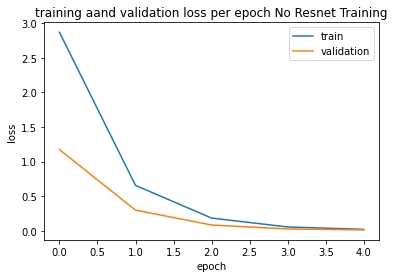

In [21]:
plt.plot(trainlosslog,label="train")
plt.plot(validlosslog,label="validation")
plt.legend()
plt.title("training aand validation loss per epoch No Resnet Training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
net = Network2(300,256,len(data.indextovocab),2)
if False:
    net.load_state_dict(torch.load('/content/gdrive/MyDrive/netwithRNtraining_v8'))
    net.eval()
net.cuda()
 
 

optimizer =  optim.Adam(net.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss(ignore_index=data.vocabtoindex["<padd>"])
trainlosslog = []
validlosslog = []
for i in range(10):
    batchkeys = creat_minibatch(data.cap_train,200)
    losslog = []
    for batchkey in batchkeys:
        length = np.max([len(data.cap_train[key[0]][key[1]]) for key in batchkey])
        imgs = []
        captions = []
        for key in batchkey:
            img = transform(Image.fromarray(np.uint8(data.imgs[key[0]])).convert('RGB'))
            caption = torch.Tensor(data.cap_train[key[0]][key[1]]).to(torch.int64)
            #caption = data.get_padd(length, data.cap_train[key[0]][key[1]])
            imgs.append(img.cpu().detach().numpy())
            captions.append(caption)
        optimizer.zero_grad()
        pad = pad_sequence(captions, padding_value = data.vocabtoindex["<padd>"], batch_first=True)
        output = net(torch.Tensor(imgs).cuda(),pad[:,:-1].cuda())
        output = loss(output.reshape(-1, output.shape[2]).cuda(), pad.view(-1).cuda())
        losslog.append(output.cpu().detach().numpy())
        optimizer.zero_grad()
        output.backward()
        optimizer.step()  
    trainlosslog.append(np.mean(losslog))
    batchkeys = creat_minibatch(data.cap_train,500)
    temp = []
    for batchkey in batchkeys:
        length = np.max([len(data.cap_train[key[0]][key[1]]) for key in batchkey])
        imgs = []
        captions = []
        for key in batchkey:
            img = transform(Image.fromarray(np.uint8(data.imgs[key[0]])).convert('RGB'))
            caption = torch.Tensor(data.cap_train[key[0]][key[1]]).to(torch.int64)
            #caption = data.get_padd(length, data.cap_train[key[0]][key[1]])
            imgs.append(img.cpu().detach().numpy())
            captions.append(caption)
        pad = pad_sequence(captions, padding_value = data.vocabtoindex["<padd>"], batch_first=True)
        output = net(torch.Tensor(imgs).cuda(),pad[:,:-1].cuda())
        output = loss(output.reshape(-1, output.shape[2]).cuda(), pad.view(-1).cuda())
        temp.append(output.item())
    with open("/content/gdrive/MyDrive/v2logg.txt", "a") as myfile:
        myfile.write(str(trainlosslog[-1]))
    print(trainlosslog)
    validlosslog.append(np.mean(temp))
    print(validlosslog)
    torch.save(net.state_dict(), '/content/gdrive/MyDrive/binetwithRNtraining_v7')

[5.1451745]
[4.0598497970684155]
[5.1451745, 3.5797606]
[4.0598497970684155, 3.1260369887223116]
[5.1451745, 3.5797606, 2.771033]
[4.0598497970684155, 3.1260369887223116, 2.4302801215970837]
[5.1451745, 3.5797606, 2.771033, 2.1741362]
[4.0598497970684155, 3.1260369887223116, 2.4302801215970837, 1.9239058542895962]
[5.1451745, 3.5797606, 2.771033, 2.1741362, 1.7398647]
[4.0598497970684155, 3.1260369887223116, 2.4302801215970837, 1.9239058542895962, 1.5528725482322074]
[5.1451745, 3.5797606, 2.771033, 2.1741362, 1.7398647, 1.4163475]
[4.0598497970684155, 3.1260369887223116, 2.4302801215970837, 1.9239058542895962, 1.5528725482322074, 1.2712132286381077]
[5.1451745, 3.5797606, 2.771033, 2.1741362, 1.7398647, 1.4163475, 1.1667694]
[4.0598497970684155, 3.1260369887223116, 2.4302801215970837, 1.9239058542895962, 1.5528725482322074, 1.2712132286381077, 1.0497417747974396]


KeyboardInterrupt: ignored

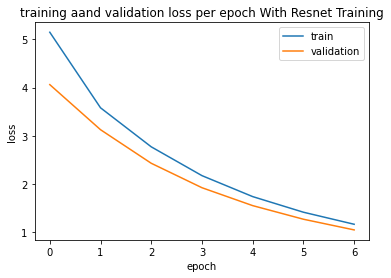

In [23]:
plt.plot(trainlosslog,label="train")
plt.plot(validlosslog,label="validation")
plt.legend()
plt.title("training aand validation loss per epoch With Resnet Training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()